<center>
<h1>STAT 654: Statistical Computing with R and Python</h1>
<h2>General Linear Models: Logit and Probit Regression</h2>
<strong>
Daniel Drennan<br>
Dr. Sharmistha Guha<br><br>
Department of Statistics<br>
Texas A&M University<br>
College Station, TX, USA<br><br>
Spring 2022<br>
</strong>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.discrete.discrete_model import Logit, Probit
from sklearn.linear_model import LogisticRegression

C:\Users\danjd\miniconda3\envs\stats\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Generalized Linear Models

This notebook covers logistic and probit regression in particular, 
which are particular instances of a family of generalized linear models (GLMs).
We will see how to fit logistic regression models using scikit-learn and statsmodels.
A very brief outline of theory is given below. Skip ahead for the code examples.

Generalized linear models are regression models from the exponential family of distributions
together with a link function to the distribution. A density or mass function $f$ is said to 
be part of the exponential family of distributions if it can be written as
$$
    f(x | \theta) = h(x) c(\theta) \exp\left\{\sum_{i=1}^{d} t_i(x) w_i(\theta)\right\},
    \qquad \theta \in \mathbb{R}^{d}.
$$
(Note $x$ and $\theta$ may be scalars or vectors.)
Common distributions from this family include the normal, binomial, Poisson, and gamma distributions.
For the curious, a primer on exponential families (with no connection to GLMs) is available
[here](https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter8.pdf).
Wikipeida also has articles on the [exponential family](https://en.wikipedia.org/wiki/Exponential_family)
and [GLMs](https://en.wikipedia.org/wiki/Generalized_linear_model). The Wikipedia articles are fantastic
references once you've learned the theory but are not necessarily good for learning theory. Our focus is
on logistic and probit regression—two models for a binary response variable.

For a general GLM, let $Y_1, \ldots, Y_n \overset{iid}{\sim} F$ follow an exponential family distribution
with a vector of covariates $x_i = (x_{i1}, \ldots, x_{ij})'$. The mean is then given by
$$
    E Y_i | x_i = \mu = g^{-1}(x_i' \beta), \qquad x_i, \beta \in \mathbb{R}^{p}.
$$
The function $g$ is determined by the model we choose. Generally, $g$ is monotonic and differentiable
almost everywhere. For a logistic regression, the link function is $\log(\frac{p_i}{1 - p_i}) = x_i'\beta$,
where $p_i = P[Y_i = 1 | x_i]$. In a probit model, we have $\Phi(Y_i) = x_i'\beta$, where $\Phi$ is the
cdf for a standard normal distribution. (NB. Both of these are differentiable functions over the real line).

Like ordinary least squares (OLS), in GLMs we estimate $\beta$ through maximum likelihood estimation. Unlike
OLS, the vector $\beta$ in a GLM does not always have an analytic solution. In such cases, the log-likelihood
is maximized numerically using either gradient descent, Newton-Raphson, or another root-finding algorithm to
arbitrary precision. Standard error estimates for $\hat{\beta}$ are obtained using normal approximations.
Goodness of fit is quantified through model deviance instead of the residual sum of squares. The deviance for
a GLM is determined by the exponential family and link function used.

## Code examples

The dataset I am using for this module is the *Challenger* data, which associates shuttle launch failures with
ground temperatures for shuttle launch trials leading up to the space shuttle Challenger disaster. The dataset
is taken from Casella and Berger's *Statistical Inference*.

In [2]:
df = pd.read_csv("../data/challenger.csv")
df.head()

,flight,failure,temp
0,14,1,53
1,9,1,57
2,23,1,58
3,10,1,63
4,1,0,66


Flight numbers for us contain no useful information. They are records from the original data but are not useful
as predictor variables in a model. A plot of the other two columns is given below.

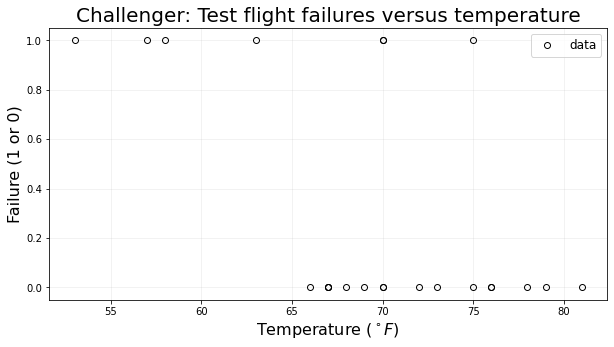

In [3]:
fig = plt.figure(figsize = (10, 5))
plt.title("Challenger: Test flight failures versus temperature", fontsize=20)
plt.xlabel("Temperature $(^\circ F)$", fontsize=16)
plt.ylabel("Failure (1 or 0)", fontsize = 16)
plt.grid(alpha = 0.2)
plt.plot(df.temp, df.failure, 'ko', mfc="none", label = "data")
plt.legend(fontsize=12)
plt.show()

We can see from the plot that there are no successful launches below 65 degrees but there are failures above 65
degrees. Clearly a model should put a high risk of failure at lower temperatures and smoothly transition risk at
temperatures near 65 degrees. We will fit logistic (logit) and probit regression models to the data and replot
this figure.

The first models we will fit are logistic regressions. In the scikit-learn class, note the `penalty` argument
defaults to an L2 norm. This means the model is being fit using ridge regression by default. To fit a logistic
regression without the penalty, we need to specify `penalty = 'none'`. Try changing the fits in this notebook
for yourself to see how the model estimates change.

In [4]:
# Fitting a scikit learn model first, noting penalty = "none" as a required argument
x = df.temp.values.reshape(-1, 1)
y = df.failure.values

sklearn_logit_model = LogisticRegression(penalty="none").fit(x, y)

print("sklearn logit fit: intercept = {:.4f}, slope = {:.4f}".format(
    float(sklearn_logit_model.intercept_),
    float(sklearn_logit_model.coef_[0, 0])
))

sklearn logit fit: intercept = 15.0429, slope = -0.2322


In [5]:
# Require a matrix to fit a Logit model in statsmodels
X = np.c_[np.ones(x.size), x]
sm_logit_model = Logit(y, X).fit()

sm_logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Mar 2022   Pseudo R-squ.:                  0.2813
Time:                        23:21:33   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0429      7.379      2.039      0.041       0.581      29.505
x1            -0.2322      0.108     -2.145      0.032      -0.444      -0.020
==============================================================================
"""

All I really have to comment on is the consistency of the parameter estimates. Observe both models have the
same parameter estimates. As seen in previous notebooks, scikit-learn does not provide uncertainty estimates
whatsoever. If we want model uncertainty (as statisticians we generally do), then we either need to code the
theory ourselves or use statsmodels to get standard errors. Next we'll fit the probit model.

In [6]:
sm_probit_model = Probit(y, X).fit()
sm_probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.442994
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                         Probit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Mar 2022   Pseudo R-squ.:                  0.2791
Time:                        23:21:33   Log-Likelihood:                -10.189
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004972
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7750      4.029      2.178      0.029       0.879      16.671
x1            -0.1351      0.058     -2.314      0.021      -0.250      -0.021
==============================================================================
"""

Next we plot the two models with the data.

In [7]:
Xp = np.c_[
    np.ones(1000),
    np.linspace(50, 85, 1000)
]

y_logit = sm_logit_model.predict(Xp)
y_probit = sm_probit_model.predict(Xp)

Note the parameter estimates are different due to the link functions used. The probabilities for the two models will also
be slightly different, but are similar (see the next plot).

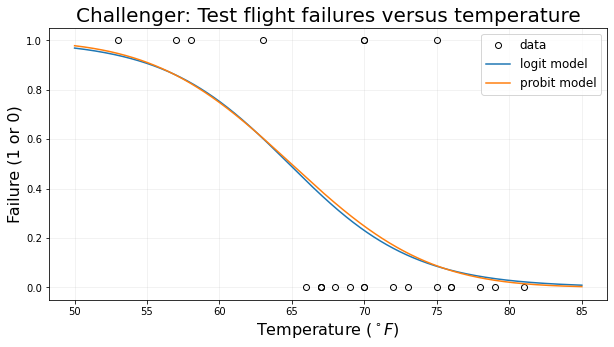

In [8]:
fig = plt.figure(figsize = (10, 5))
plt.title("Challenger: Test flight failures versus temperature", fontsize=20)
plt.xlabel("Temperature $(^\circ F)$", fontsize=16)
plt.ylabel("Failure (1 or 0)", fontsize = 16)
plt.grid(alpha = 0.2)
plt.plot(df.temp, df.failure, 'ko', mfc="none", label = "data")
plt.plot(Xp[:, 1], y_logit, "C0", label = "logit model")
plt.plot(Xp[:, 1], y_probit, "C1", label = "probit model")
plt.legend(fontsize=12)
plt.show()

The plot above shows the similarity of the two models. As we would expect, at 65 degrees, both models approximate the
probability of failure as 0.5. Confidence intervals are not shown here but can be obtained using the delta method. I may
revise this to include an example in the future.